## Генерация текстов 
*Необходимо реализовать модель, генерирующую текста. В качестве данных возьмем сборник цитат умных людей.*

[cсылка на датасет](https://github.com/alvations/Quotables/blob/master/author-quote.txt)



Будем использовать двухслойную рекуррентную нейронную сеть $LSTM$ с двумя линейными слоями на выходе.
На вход модели будем продавать вектора, которые являются результатом работы алгоритма word2vec


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output
import gensim
import gensim.downloader
%matplotlib inline

#### Загрузка и предобраотка текста

In [ ]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2020-12-07 16:20:07--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  --.-KB/s    in 0.1s    

2020-12-07 16:20:07 (38.4 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



In [ ]:
lines = [re.sub('[^a-z -]', '', x.split('\t')[1].lower()).split() 
         for x in open('author-quote.txt').readlines()]

Всего цитат: 39269


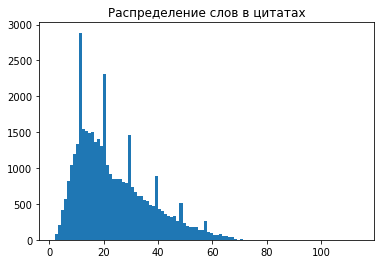

In [ ]:
print('Всего цитат: {}'.format(len(lines)))

plt.hist(list(map(len, lines)), bins=100)
plt.title('Распределение слов в цитатах');

In [ ]:
np.random.seed(777)
torch.manual_seed(777)

In [ ]:
class Vocabulary():
    def __init__(self, sentences):
        all_words = set()
        for line in sentences:
            all_words |= set(line)

        all_words = list(sorted(all_words)) + ['<go>', '<eos>']

        self.word_to_id = {x[1]: x[0]
                           for x in enumerate(all_words)}

        self.id_to_word = {x[0]: x[1]
                           for x in enumerate(all_words)}

        self.size = len(all_words)

    def encode(self, line):
        return [self.word_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_word[x] for x in tokens])


vocab = Vocabulary(lines)

In [ ]:
class Quotes(Dataset):
    def __init__(self, lines, vocab):
        self.lines = lines
        self.vocab = vocab
        self.go = self.vocab.word_to_id['<go>']
        self.eos = self.vocab.word_to_id['<eos>']

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.lines[idx])
        _input = np.array([self.go] + tokens)
        _output = np.array(tokens + [self.eos])
        return _input, _output


dataset = Quotes(lines, vocab)

In [ ]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [ ]:
train_size = int(len(dataset) * 0.85)
test_size = len(dataset) - train_size
train, test = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train, shuffle=True,
                              batch_size=64,
                              collate_fn=compose_batch, 
                              drop_last=True)

test_dataloader = DataLoader(test, shuffle=True,
                             batch_size=64,
                             collate_fn=compose_batch, 
                             drop_last=True)

#### Создание модели

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocabulary_size, batch_size=64, embedding_size=128, hidden_size=256, layers=2, pretrained_emb=None):
        super().__init__()
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        if pretrained_emb is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_emb, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabulary_size, embedding_size)        

        self.lstm = nn.LSTM(embedding_size, hidden_size, layers)
        
        self.classifier = nn.Sequential(nn.Linear(hidden_size, 2*hidden_size), nn.Linear(2*hidden_size, vocabulary_size))

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(embedding, lengths)
        hidden_cell = (torch.zeros(self.layers, self.batch_size, self.hidden_size).cuda(),
                       torch.zeros(self.layers, self.batch_size, self.hidden_size).cuda())
        
        output, _ = self.lstm(embedding, hidden_cell)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=500):
        hidden_cell = (torch.zeros(self.layers, 1, self.hidden_size),
                       torch.zeros(self.layers, 1, self.hidden_size))
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
               len(line) < max_len:
            token = torch.tensor([[vocab.word_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, hidden_cell = self.lstm(embedding, hidden_cell)
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_word[new_token_id]
            line = line + current_token + ' ' 
        return line

In [ ]:
# model = RNN(vocab.size, batch_size=64,
#             embedding_size=300,
#             hidden_size=512, layers=2)    

In [ ]:
embedding_size = 300
w2v_model = gensim.downloader.load('glove-wiki-gigaword-' + str(embedding_size))

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
embed_matrix = list()
bad_words = 0
for i in range(vocab.size):
    word = vocab.id_to_word[i]
    try:
        vec = w2v_model.wv[word]
    except KeyError:
        vec = np.random.rand(embedding_size)
        bad_words += 1
    embed_matrix.append(vec)  

print('Word2vec не понял примерно {:.2}% слов\
\nЗаменим их на случайные вектора\n'.format(bad_words/vocab.size * 100))

Word2vec не понял примерно 6.3% слов
Заменим их на случайные вектора



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
model = RNN(vocab.size,
            embedding_size=embedding_size,
            hidden_size=512, layers=2, pretrained_emb=torch.from_numpy(np.array(embed_matrix, dtype=np.float32)))   

model = model.cuda()

#### Обучение модели и получения предсказания

In [ ]:
def train(epoch, lerning_rate):
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lerning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(reduction='none')
    train_losses, test_losses = list(), list()
    try:
        for num in range(1, epoch+1):
            train_loss_epoch, test_loss_epoch = list(), list()
            for i, (go, eos, mask, length) in enumerate(train_dataloader):
                go = go.cuda()
                eos = eos.cuda()
                mask = mask.cuda()

                model.zero_grad()
                prediction = model(go, length).transpose(0, 1).transpose(1, 2)
                loss = (criterion(prediction, eos)*mask.float()).sum()
                loss = loss / mask.sum()
                loss.backward()
                [x.grad.clamp_(-1, 1) for x in model.parameters() if x.grad is not None]
                optimizer.step()
                train_loss_epoch.append(np.exp(loss.cpu().item()))

                go, eos, mask, length = next(iter(test_dataloader))
                go = go.cuda()
                eos = eos.cuda()
                mask = mask.cuda()
                prediction = model(go, length).transpose(0, 1).transpose(1, 2)
                loss = (criterion(prediction, eos)*mask.float()).sum()
                loss = loss / mask.sum()
                test_loss_epoch.append(np.exp(loss.cpu().item()))

            train_losses.append(np.mean(train_loss_epoch))
            test_losses.append(np.mean(test_loss_epoch))

            clear_output(True)
            plt.figure(figsize=(15, 5))
            plt.plot(train_losses, label='Train', linestyle = '-', marker = '.')
            plt.plot(test_losses, label='Test', linestyle = '-', marker = '.')
            plt.xlabel('Iteration')
            plt.ylabel('Perplexity')
            plt.title('Epoch: {0}     (Train/Test) loss: {1:.3f}/{2:.3f}'.format(
                       num, train_losses[-1], test_losses[-1]))
            plt.grid(True)
            plt.legend()
            plt.show()
    except KeyboardInterrupt:
        pass

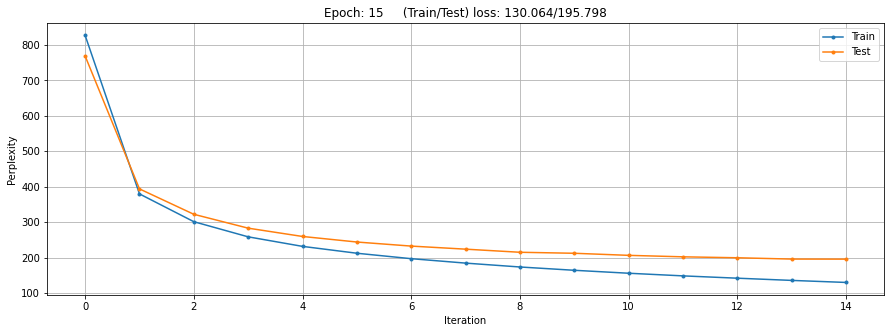

In [ ]:
train(15, 0.0001)

In [ ]:
model.cpu()

RNN(
  (embedding): Embedding(29376, 300)
  (lstm): LSTM(300, 512, num_layers=2)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=29376, bias=True)
  )
)

In [ ]:
ansver = list()
for _ in range(10):
  result = model.generate(vocab)
  ansver.append(result + 2*'\n')

print(*ansver)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


wrapped over in june definitely coffee through school and a few years from the last years tour astray <eos> 

 now all patriots the world in men are either in the derogatory men <eos> 

 i guess that compared to me would think of music as the arts couldnt aspire to be taught me was feeling such love but i like to her fun <eos> 

 i want to be the underdog i love again we better <eos> 

 i really wanted to go to keep taking in tour but as service as there is to say <eos> 

 i feel fooling by leather and tomato navigation so i often think of the senate and the web realization of uncomfortable <eos> 

 weve been treated in a medium on this city dark - rather stuff less than to have a very big cousin trap and theyll when there are certain problems and voluntary the best you can go on and say love even means <eos> 

 when someone injury you take your dollars then you still hope over all <eos> 

 it is the glory of flux building brimming requires outer instructions <eos> 

 when a man he had